### Imports

In [3]:
import numpy as np
import colorsys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Biowavelenght

'''
    == A few notes about color ==

    Color   Wavelength(nm) Frequency(THz)
    Red     620-750        484-400
    Orange  590-620        508-484
    Yellow  570-590        526-508
    Green   495-570        606-526
    Blue    450-495        668-606
    Violet  380-450        789-668

    f is frequency (cycles per second)
    l (lambda) is wavelength (meters per cycle)
    e is energy (Joules)
    h (Plank's constant) = 6.6260695729 x 10^-34 Joule*seconds
                         = 6.6260695729 x 10^-34 m^2*kg/seconds
    c = 299792458 meters per second
    f = c/l
    l = c/f
    e = h*f
    e = c*h/l

    List of peak frequency responses for each type of 
    photoreceptor cell in the human eye:
        S cone: 437 nm
        M cone: 533 nm
        L cone: 564 nm
        rod:    550 nm in bright daylight, 498 nm when dark adapted. 
                Rods adapt to low light conditions by becoming more sensitive.
                Peak frequency response shifts to 498 nm.


'''

### EEG spectral peaks to color palette

**Evolution of color palettes from multiple successive time series**


Everything started when I realized that the visible spectrum was spanning almost exactly one octave (400THz-780THz).
My intention was to map the frequencies extracted with the biotuner onto the visible spectrum, one step higher than the audible range. With the visible spectrum spanning one octave, it means that any frequency outside of the visible spectrum, that is shifted by a factor of 2^n octaves on the direction of the visible spectrum will almost always fall within the visible spectrum.
We will see how to construct a color in Hue-Saturation-Value (HSV) format from an EEG time series. First, we neeed to extract spectral peaks from the EEG signal. Then each peaks are shifted one octave up iteratively until the visible spectrum is reached. This **frequency value** will determine the **hue** of the color. The **amplitude** is determined by the amplitude of the peak, while the **saturation** is determined as the average harmonicity of the peak.






In [23]:

peaks = [2.3, 5.4, 7.3, 12]
def peaks_ratios_harm(peaks, function=dyad_similarity):
    harm = []
    for p in peaks:
        harm_temp = []
        for p2 in peaks:
            harm_temp.append(function(p/p2))
        harm.append(np.mean(harm_temp))
    peaks_ordered = [x for _, x in sorted(zip(harm, peaks))]
    return harm

harm = peaks_ratios_harm(peaks)
harm

[29.230555004080916, 31.2177663071052, 27.761564423267817, 30.723065978426312]

Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5


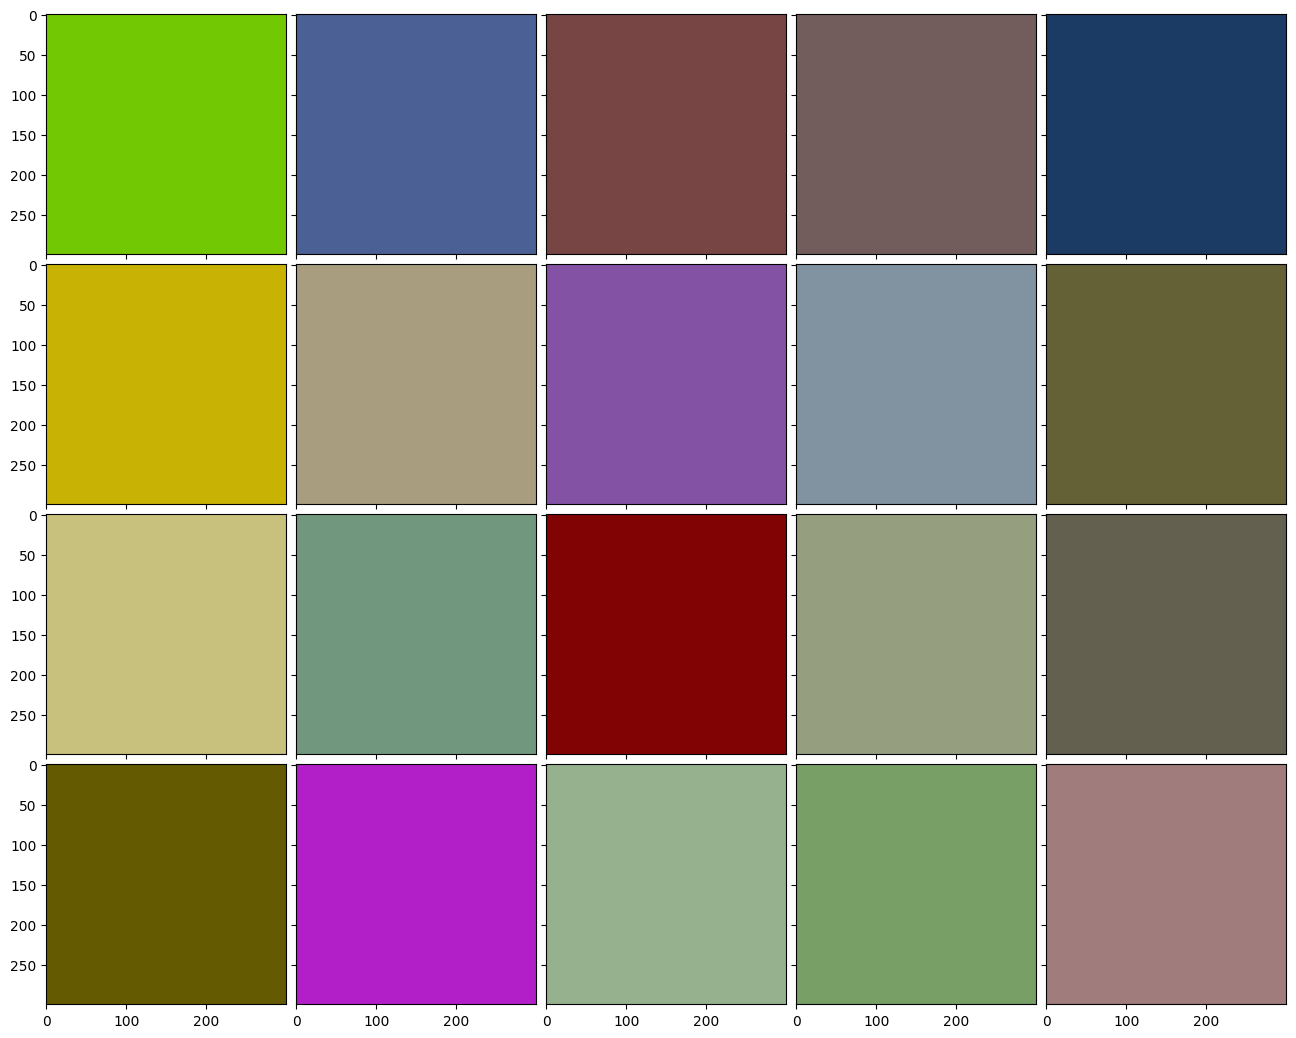

In [33]:
from biotuner.biocolors import scale2freqs, audible2visible, wavelength_to_rgb

# load dataset
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

# take single time series
data_ts = data[30]
tmin = 0
tmax = 5000
window = 1000

timestamps = list(range(tmin, tmax, window))
peaks_tot = []
amps_tot = []
harm_tot = []

# extract spectral peaks for all successive window
for t in range(len(timestamps)):
    try:

        win = [timestamps[t], timestamps[t+1]] 
        #print(win[0], win[1])
        data_ = data_ts[win[0]:win[1]] # Define data (single time series)
        # Initialize biotuner object
        biotuning = compute_biotuner(1000, peaks_function='EMD', precision=0.1, n_harm=10,
                    ratios_n_harms=10, ratios_inc_fit=False, ratios_inc=False)
        # Extract spectral peaks
        biotuning.peaks_extraction(data_, ratios_extension = True, max_freq=50)
        peaks = list(biotuning.peaks)
        amps = np.array(list(biotuning.amps))
        amps = np.interp(amps, (amps.min(), amps.max()), (100, 200)).astype('uint8')
        harm = peaks_ratios_harm(biotuning.peaks)
        harm = np.array(harm)
        harm = np.interp(harm, (harm.min(), harm.max()), (50, 250)).astype('uint8')
        harm_tot.append(harm)
        peaks_tot.append(peaks)
        amps_tot.append(amps)
        
    except IndexError:
        pass
         
# rescale amplitude
#amps_tot = ((amps_tot - np.min(amps_tot)) * (1/(np.max(amps_tot) - np.min(amps_tot)) * 255)).astype('uint8')    

img_array = []
# use frequency and amplitude information to derive HSV values.
for peaks, amp, harm in zip(peaks_tot, amps_tot, harm_tot):
    #print(ts_n)
    i = 0
    for p, a, h in zip(peaks, amp, harm):

        _, _, nm, octave = audible2visible(p)
        #print(octave)
        rgb = wavelength_to_rgb(nm)
        hsv = colorsys.rgb_to_hsv(rgb[0]/float(255),rgb[1]/float(255), rgb[2]/float(255))
        hsv = np.array(hsv)
        hsv = ((hsv - 0) * (1/(1 - 0) * 255)).astype('uint8')
        hsv = list(hsv)
        
        hsv[2] = a
        hsv[1] = h
        hsv = tuple(hsv)
        img = Image.new('HSV', (300, 300), hsv)
        
        img_array.append(img)


        
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(len(peaks_tot), len(peaks_tot[0])),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, img_array):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

### Biotuning to color palette

In this example, we will use a tuning to derive a color palette. To do so, we will create a function that takes a scale as input and derives **hue**, **saturation** and **luminance** values. We derive a set of frequencies from the scale. Then, the **hue** corresponds to the frequency value shifted in the visible spectrum range. The **saturation** corresponds to the averaged harmonicity between the scale step and all the other scale steps. Finally, the **luminance** is set to a constant, but there could be ways to derive luminance based on other aspects of the scale strucure. 

In [5]:
from biotuner.metrics import tuning_cons_matrix

def viz_scale_colors(scale, fund, title=None):
    # set default title
    if title == None:
        title = 'Color palette derived from biological tuning'
    min_ = 0
    max_ = 1
    # convert the scale to frequency values
    scale_freqs = scale2freqs(scale, fund)
    # compute the averaged consonance of each step
    scale_cons, _ = tuning_cons_matrix(scale, dyad_similarity, ratio_type='all')
    # rescale to match RGB standards (0, 255)
    scale_cons = ((np.array(scale_cons) - min_) * (1/max_ - min_) * 255).astype('uint8')
    img_array = []
    hsv_all = []
    for s, cons in zip(scale_freqs, scale_cons):
        # convert freq in nanometer values
        _, _, nm, octave = audible2visible(s)
        # convert to RGB values
        rgb = wavelength_to_rgb(nm)
        # convert to HSV values
        hsv = colorsys.rgb_to_hsv(rgb[0]/float(255),rgb[1]/float(255), rgb[2]/float(255))
        hsv = np.array(hsv)
        # rescale
        hsv = ((hsv - 0) * (1/(1 - 0) * 255)).astype('uint8')
        hsv = list(hsv)
        # define the saturation
        hsv[1] = int(cons)
        # define the luminance
        hsv[2] = 200
        hsv = tuple(hsv)
        hsv_all.append(hsv)
        img = Image.new('HSV', (300, 300), hsv)
        img_array.append(img)

    # Figure parameters
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, int(len(scale_freqs)/2)),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for ax, im in zip(grid, img_array):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    plt.show()
    return hsv_all

Number of peaks : 5
Number of extended peaks :  13


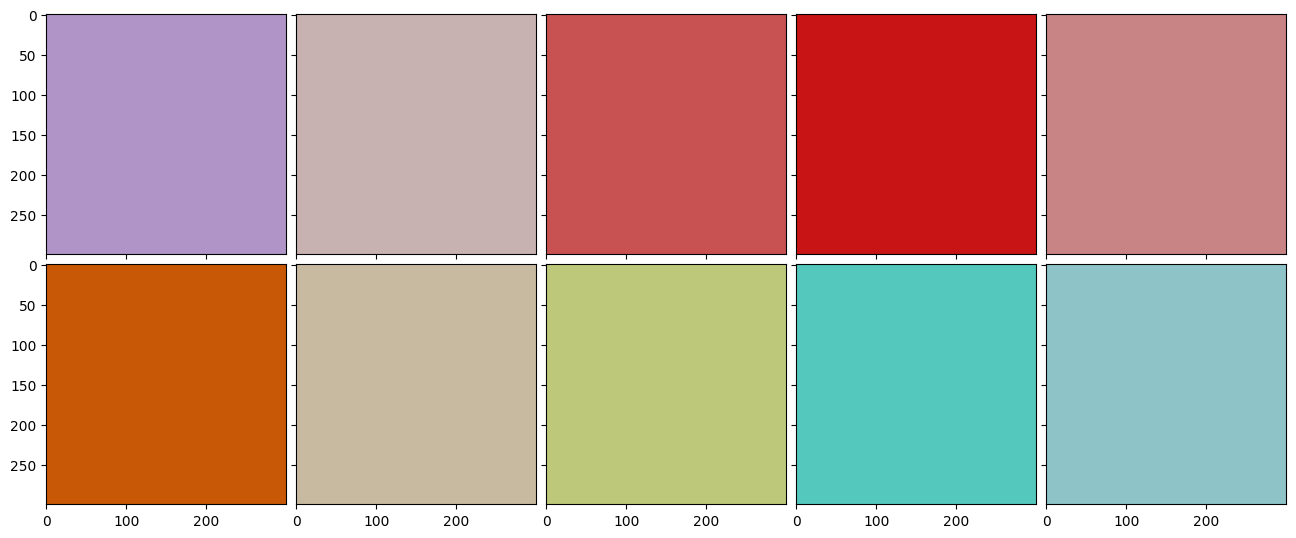

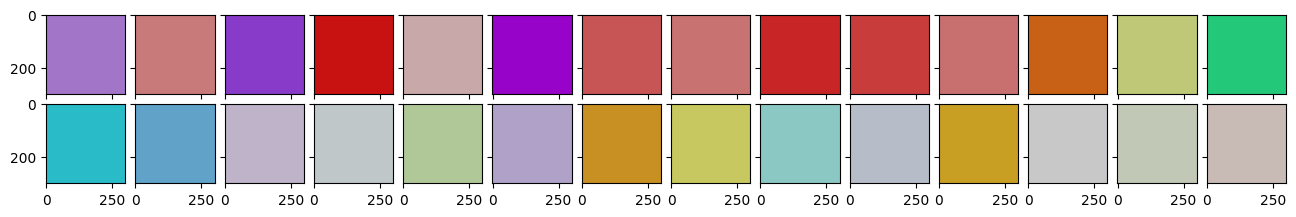

In [39]:
# choose a single time series
data_ = data[37]

# Initialize biotuner object
biotuning = compute_biotuner(1000, peaks_function = 'EMD', precision = 0.1, n_harm = 30,
                    ratios_n_harms = 10, ratios_inc_fit = False, ratios_inc = False) 

# Extract spectral peaks
biotuning.peaks_extraction(data_, max_freq = 50)

# Extend spectral peaks based on interharmonic concordance
biotuning.peaks_extension(method = 'harmonic_fit',
                          harm_function = 'mult', cons_limit = 0.1)

# Take the scales from peaks ratios and extended peaks ratios
scale1 = [1]+biotuning.peaks_ratios
scale2 = [1]+biotuning.extended_peaks_ratios

# Visualize the color palette associated with the scales
hsv1 = viz_scale_colors(scale1, fund = biotuning.peaks[0])
hsv2 = viz_scale_colors(scale2, fund = biotuning.extended_peaks[0])

### Animation of brain color palette

In [49]:
def animate_colors(colors, duration, frames_per_second, filename='test'):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Create a rectangular patch
    rect = plt.Rectangle((0, 0), 1, 1, color=hsv_to_rgb(colors[0]))
    ax.add_patch(rect)

    def update(frame):
        color_index = int(frame // (frames_per_second * duration / len(colors)))
        next_color_index = (color_index + 1) % len(colors)
        color_weight = frame % (frames_per_second * duration / len(colors)) / (frames_per_second * duration / len(colors))
        color = hsv_to_rgb((colors[color_index][0] + (colors[next_color_index][0] - colors[color_index][0]) * color_weight,
                            colors[color_index][1] + (colors[next_color_index][1] - colors[color_index][1]) * color_weight,
                            colors[color_index][2] + (colors[next_color_index][2] - colors[color_index][2]) * color_weight))
        rect.set_color(color)

    # Create animation using the update function
    ani = FuncAnimation(fig, update, frames=np.linspace(0, frames_per_second * duration - 1, frames_per_second * duration), repeat=True)
    #plt.show()
    # embedding for the video
    #html = display.HTML(ani)
    
    # draw the animation
    #display.display(html)
    #plt.close()
    ani.save('{}.gif'.format(filename))

In [ ]:
#from biotuner.biocolors import animate_colors

# rescale HSV colors between 0 and 1
hsv_scaled = []
for h in hsv1:
    hsv_scaled.append([x / 255.0 for x in h])

# create animation
animate_colors(hsv_scaled, 2, 60, filename='braincolors_fast')



![SegmentLocal](images/braincolors.gif "segment")

### Palette from harmonic positions

In [ ]:
# Define a fundamental color (defaults to Red; lower chakra)

# Define the harmonic range (n octaves)

# Assign harmonic positions to the color wheel

# Extract harmonic position and find the associated colors